In [1]:
import multiprocessing
from multiprocessing.pool import ThreadPool
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.problem import StarmapParallelization
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize

import optimize as op

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


In [2]:
opt = op.corgiOptimize()
opt.L = 0.2
opt.T_sw = 1.4
opt.getLiftoffState()
print("Initial Cost", opt.objective(opt.bp_init_guess))


class CorgiProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=24,
                         n_obj=1,
                         n_ieq_constr=24,
                         xl=np.array([0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05,
                                      0.33, 0.00, 0.01, -0.05, 0.01, -0.05]),
                         xu=np.array([0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5,
                                      0.35, 0.02, 0.5, 0.5, 0.5, 0.5]),
                         **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        f  = opt.objective(x)

        g1 = -1 * opt.innerWsPFConstraint(x)
        g2 = -1 * opt.outerWsPFConstraint(x)
        g3 = np.abs(opt.velocityConstraint(x)) - 0.01
        print("g3", np.average(g3))
        g = np.hstack((g1, g2))
        g = np.hstack((g, g3))

        out["F"] = [f]
        out["G"] = list(g)

# initialize the thread pool and create the runner
# n_proccess = 12
# pool = multiprocessing.Pool(n_proccess)
# runner = StarmapParallelization(pool.starmap)

# initialize the thread pool and create the runner
n_threads = 16
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
problem = CorgiProblem(elementwise_runner=runner, elementwise_evaluation=True)
# problem = CorgiProblem()


iter 1 cost -5.579751413893065
Initial Cost -5.579751413893065


In [3]:
algorithm = NSGA2(
    pop_size=60,
    n_offsprings=15,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [4]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 100)

In [5]:

result = minimize(ConstraintsAsPenalty(problem, 5),
                  algorithm,
                  termination,
                  seed=1,
                  save_history=False,
                  verbose=False)

pool.close()


iter 2 cost 1151.6899228554423
iter 3 cost 1073.2517323166014
g3 1.4351645672428877
iter 4 cost 910.6498352804584
iter 5 cost 1230.677503839852
iter 6 cost 1194.4679078858835
iter 7 cost 821.591262781644
g3iter 8 cost 974.7543615036807
 1.4087527861567741
iter 9 cost 873.5108662875472
g3 1.4700095832322715
iter 10 cost 893.5288615343719
iter 11 cost 1159.7522272051665
g3 1.4041027888923843
iter 12 cost 1273.736158689016
g3 1.1879227105402863
iter 13 cost 1045.5944227044256
iter 14 cost 1289.0944927793776
g3 0.9714706750508
iter 15 cost 1204.176875494191
g3 1.1418507119386567
g3 1.0513603366118671
g3 1.202159755853228
g3 1.3878850382744197
g3 1.3814748334322047
g3 1.1198427225869636
g3 1.2231742423610008
g3 1.5225694600298116
iter 16 cost 890.5129704429779
iter 17 cost 1451.4285302700505
g3 1.2373356071268509
g3 1.0206098076054984
iter 18 cost 877.5215039579682
iter 19 cost 1112.5058557080033
iter 20 cost 1081.1457360328172
g3 1.2006475699999548
g3 1.4775520603266779
g3 1.23819855369231

[ 3.30153982e-01  1.24949135e-03  3.57370018e-01  3.54517822e-01
  1.43970481e-02 -4.69910155e-02  3.30043238e-01  1.70555370e-04
  2.58158235e-01  3.04077865e-01  1.49579925e-02 -4.95494632e-02
  3.30129303e-01  3.37312941e-04  1.41934219e-01  1.78525773e-01
  1.21716338e-02 -4.75710505e-02  3.30349912e-01  1.71985792e-03
  2.80738705e-01 -4.74304683e-02  1.17916577e-02 -4.86672918e-02]
[173.95776676]
---
Optimized Bezier Profile:
[[ 3.30153982e-01  1.24949135e-03  3.57370018e-01  3.54517822e-01
   1.43970481e-02 -4.69910155e-02]
 [ 3.30043238e-01  1.70555370e-04  2.58158235e-01  3.04077865e-01
   1.49579925e-02 -4.95494632e-02]
 [ 3.30129303e-01  3.37312941e-04  1.41934219e-01  1.78525773e-01
   1.21716338e-02 -4.75710505e-02]
 [ 3.30349912e-01  1.71985792e-03  2.80738705e-01 -4.74304683e-02
   1.17916577e-02 -4.86672918e-02]]


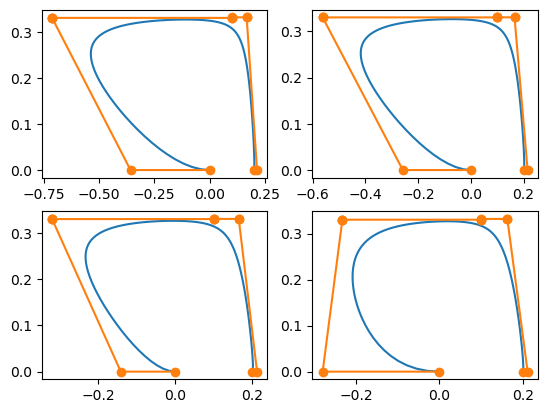

In [6]:
print(result.X)
print(result.F)
min_ = np.min(result.F, axis=0)

opt.plotResult(result.X)

In [7]:
# print(result.pop.get("X"))
bp = np.array([0.034815,    0.00341456,  0.01004385, -0.03486108,  0.02724615, -0.08330442,
 0.03140377,  0.00436724,  0.01425195, -0.03556327,  0.02642443, -0.09868557,
 0.03100124,  0.0039261,   0.02582531, -0.02476453,  0.01291202, -0.04367011,
 0.03027373,  0.00167466,  0.0149596,  -0.03968913,  0.02813969, -0.09163613])

bp = np.array([ 3.90475000e-02,  1.26541517e-02,  1.29990659e-02,
        -9.43200192e-02,  5.01530731e-02, -8.84345508e-02,
         3.14253998e-02,  6.60885379e-03,  1.64677686e-01,
        -7.29851060e-02,  4.03009612e-02, -5.70694902e-02,
         3.10178224e-02,  1.41883854e-02,  2.16441144e-02,
         3.29020311e-02,  1.51452422e-02, -9.34873236e-02,
         3.01523820e-02,  1.95010099e-03,  4.55182621e-02,
        -9.75865250e-02,  2.84592035e-02, -5.60758920e-02])
# opt.exportBezierData(bp)
opt.exportBezierData(result.X)

# candidate
# L 0.2 T 0.6
#4
#6
#8
# L 0.15 T 0.3

data export
sbrio exported to ./csv_trajectory/20230828/2023-08-30_traj_400_1.csv
data export
webot exported /home/guanlunlu/corgi_webots/controllers/supervisor/2023-08-30_traj_400_1.csv


In [8]:
opt = op.corgiOptimize()
opt.L = 0.2
opt.T_sw = 0.6
opt.getLiftoffState()
print("Initial Cost", opt.objective(result.X))

iter 1 cost 111.96817698540433
Initial Cost 111.96817698540433
